In [29]:
%load_ext autoreload
%autoreload 2

import numpy as np
import numpy.random as rd
from scipy import stats
import copy
import os
import time
import csv

from pyperplan import planner as pl
from pyperplan import search as sc
from pyperplan.planner import (
    find_domain,
    HEURISTICS,
    search_plan,
    SEARCHES,
    validate_solution,
    write_solution,
)
from pyperplan.task import Operator, Task
from pyperplan.heuristics.heuristic_base import Heuristic
from pyperplan.search.a_star import greedy_best_first_search_test as gbfs
from pyperplan.search.a_star import TimeoutError
from typing import Set

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Planning Graph

In [30]:
# define the planning graph
class RelaxedGraph(object):
    
    def __init__(self): # initialise the Graph
        self.num_of_levels: int = 0
        self.act = {0: None}
        self.prop = {}
        self.fixed_point = False
        
            

class RelaxedPlanningGraph(object):
    
    def __init__(self, domain_file: str, problem_file: str):
        # initialise the relaxed planning graph
        self.task = pl._ground(pl._parse(domain_file, problem_file))
        self.graph = None
        self.plan = None
        self.hff = -1 # not yet generated
        self.dom = domain_file
        self.prob = problem_file
        self.success = False # whether successfully generated or not
        
    def create(self, max_level, state = None):
        # create the planning graph with a initial state specified
        # return the level of relaxed graph generated, -1 if reached fixed point, -2 if reached max depth
        self.graph = RelaxedGraph()
        if state is not None:
            self.graph.prop = {0: set(state)}
        else:
            self.graph.prop = {0: set(self.task.initial_state)}
        goal_set = self.task.goals
 
        for level in range(max_level+1):
            current_props = self.graph.prop[level]
            # if the goal has been satisfied
            if Task.goal_reached(self.task, current_props):
                self.success = True
                return level
            
            # else expand the relaxed graph
            self.graph.act[level+1] = set([op for op in self.task.operators if op.applicable(current_props)])
            
            next_props = current_props.copy()
            for op in self.graph.act[level+1]:
                next_props = next_props | op.add_effects
            
            if len(current_props) == len(next_props):
                return -1 # reached fixed point before finding the goal
            self.graph.prop[level+1] = next_props
        
        return -2 #reached max depth
        
    def hff_plan(self):
        # generate a relaxed plan with hff 
        # first return error if graph not successfully generated
        # return hff, -1 if failed
        if self.graph is None:
            print("Graph not yet generated")
            return -1 # graph not yet created
        if not self.success:
            print("Invalid graph")
            return -1 # graph does not reach goal state
        
        # otherwise start backtrace
        # setup g_k
        current_goal = set(self.task.goals.copy())
        k = len(self.graph.act.keys())-1
        self.plan = {}
        for i in range(k, 0, -1):
            act_set = set()
            # select the minimum set of actions that r-satisfied current goal
            for a in self.graph.act[i]:
                for eff in a.add_effects:
                    if eff in current_goal:
                        current_goal.remove(eff)
                        act_set.add(a)
            # update the current goal to be the goals for previous layer
            for a in act_set:
                current_goal.update(a.preconditions)
                
            # update the final plan
            self.plan[i] = list(act_set)

        
        if current_goal.issubset(self.graph.prop[0]):
            count = 0
            for layer in self.plan.values():
                count+=len(layer)
            self.hff = count
            return self.hff
        else:
            print("something went wrong during planning")
            return -1
            
            
        

In [31]:
# rpl = RelaxedPlanningGraph("benchmarks/blocks/domain.pddl","benchmarks/blocks/task03.pddl")

# rpl.create(999)

# graph = rpl.graph

# for o in rpl.task.operators:
#     print(o.name)

# Feature Vector 

In [32]:
def generate_feature_vec_relaxed(planning_graph, state, max_level):
    """
    Generate the feature vector followed by the paper from the input (problem, state) pair as described by the paper
    Please notice that action and operator are referring to the same type Operator within this function
    
    Inputs
    ----------
    planning_graph: the relaxed planning graph DAG pi
    state: the current state set of facts, it should never be the goal 
    max_level: the maximum layer allowed for ff algorithm to do forward expanding
    
    Outputs
    ----------
    feature_vec: a vector of length n + 2*n**2 + 3 representing the feature generated from the given (problem, state) pair
                 the first n values are single action feature
                 the second 2*n**2 are pairwise action feature
                 the last 3 are original heuristic value, the number of layers in pi and the number of unsatisfied goals
    """
    def get_name(op_name):
        """
        transfer an operator name from format of "(act_name v1 v2...)" to act_name string
        """
        return op_name.split(" ")[0][1:]
    
    
        
    if planning_graph.task.goals <= state:
        return feature_vec # if already the goal
    
    # get action schema and output list
    act_schema = np.array(list(set([get_name(o.name) for o in planning_graph.task.operators]))) # store names of total action schema
    n = len(act_schema)  # length of action schema
    total_len = n+2*n**2+4
    feature_vec = np.zeros(total_len) # return feature vec, first n is linear, second 2*n**2 is pairwise, last 3 is additional feature

    
    # create and get the graph
    idx = planning_graph.create(max_level, state)
    planning_graph.hff_plan()
    graph = planning_graph.graph
    act_layers = list(graph.act.values()) # list of layers generated, ith value is the list of actions connencting i-1 th states to ith states layer
    # extract linear feature
    #-------------------------------------
    # ith value indicate the num of occurance for ith action of act_schema in the entire graph 
    counter = np.zeros(n)
    for act_layer in act_layers:
        if act_layer is not None:
            for a in act_layer:
                counter[act_schema == get_name(a.name)] += 1 
    feature_vec[0:n] = counter
    
    # extract pair-wise feature
    #-------------------------------------
    # each pair a1, a2 is stored in n + [2*(n*a1+a2), 2*(n*a1+a2)+1]
    # e.g. when a1 is 1, a2 is 3, n is 5, store in 5 + [2*(8),  2*(8)+1]
    
    def to_index(n, index_a1, index_a2, adder):
        """
        return corresponding index in the position of the feature vector
        adder is either 0 or 1
        index_a1, index_a2 refer to move index in act_schema
        """
        return n+2*(n*index_a1+index_a2)+adder
    

    def append_to_dict(a, pre, eff_pos):
        """
        add action a into the dicitonary pre and eff_pos
        """
        for p in a.preconditions:
            current = pre.get(p)
            if current is None:
                current = [a]
            else:
                current.append(a)
            pre[p] = current
            
        for p in a.add_effects:
            current = eff_pos.get(p)
            if current is None:
                current = [a]
            else:
                current.append(a)
            eff_pos[p] = current
            
            return pre, eff_pos


    # define dictionary variables for comparison purpose
    # each dictionary maps a fact(proposition) to a list of actions
    pre = {}
    eff_pos = {}
    
    # add pre and eff into the empty dictionary for the first layer
    for a in act_layers[1]:
        pre, eff_pos = append_to_dict(a, pre, eff_pos)
   
    # loop through second to last action layers
    for i in range(2,len(act_layers)): 
        act_layer = act_layers[i]
        
        # update fecture vec for the entire layer based on all previously visited layers
        for a2 in act_layer:
            # count for num of occurances, use set to avoid multiple counts
            s1 = set() # feature 1 where eff a1 and pre a2 has intersections
            s2 = set() # feature 2 where pre a1 and eff a2 has intersections          
            for p in a2.preconditions:
                current = eff_pos.get(p)
                if current is not None:
                    for a1 in current:
                        s1.add(a1) 

            for p in a2.add_effects:
                current = pre.get(p)
                if current is not None:
                    for a1 in current:
                        s2.add(a1)

            # add index to feature_vec based on set generated:
            index_a2 = int(np.where(get_name(a2.name) == act_schema)[0])
            for a1 in s1:
                # update feature 1 for pair (a1, a2)
                index_a1 = int(np.where(get_name(a1.name) == act_schema)[0])
                feature_vec[to_index(n, index_a1, index_a2,0)]+=1

            for a1 in s2:
                # update feature 2 for pair (a1, a2)
                index_a1 = int(np.where(get_name(a1.name) == act_schema)[0])
                feature_vec[to_index(n, index_a1, index_a2,1)]+=1

        # update pre and eff_pos for the entire layer
        for a2 in act_layer:
            pre, eff_pos = append_to_dict(a2, pre, eff_pos)
           
    # extract final features
    #-------------------------------------
    # add heuristic value, number of layers and number of unsatisfied goals
    # number of layers:
    feature_vec[total_len - 3] = len(act_layers)
    # heuristic value hFF: (number of total actions in the plan)
    feature_vec[total_len - 2] = planning_graph.hff
    # unsatisfied goal: (number of propositions within the initial state that's not in the goal)
    ns_goals = 0
    for fact in state:
        if fact not in planning_graph.task.goals:
            ns_goals += 1
    feature_vec[total_len - 1] = ns_goals
    # largest parallel plans
    max_p_len = 0
    for layer in planning_graph.plan.values():
        l = len(layer)
        if l > max_p_len:
            max_p_len = l
    feature_vec[total_len - 4] = max_p_len

    return feature_vec

In [33]:
def find_operator(action : str, ops):
    """
    find an operator from the planning graph's ground operator lists
    
    return: the action operator if found
    """
    for op in ops:
        if op.name == action:
            return op
    return None


def read_plan(plan_file_path: str):
    """
    read all the lines from a plan file directory, remove the last line containing cost
    
    return: a list containing the ground truth plan with length equal to total cost
            or an empty array if not existed
    """
    try:
        with open(plan_file_path, "r") as f:
            # Read the lines of the file into a list of strings
            lines = [line.strip() for line in f.readlines()]
        return lines[:-1]

    except FileNotFoundError:
        return []

In [86]:
def generate_training_data(domain_file_path, task_file_path, plan_file_path, problem_num : int):
    """
    generate the feature vector matrix X together with a cost vector y from the given input
    
    Inputs
    ----------
    domain_file_path: the input domain file
    task_file_path: the input problem file
    plan_file_path: the input log file that store the optimal plan
    problem_num: the problem index for this domain
    
    Returns
    ----------
    None, None if no plan can be found (plan has cost 0)
    X : array, shape (plan_length-1, n_features)
        The input feature vec of states from initial states all the way towards the second-last state (one state before goal state)
    Y : array, shape (plan_length-1, 2)
        The input cost vector. If it's a 2D array
        The first column is the true cost pi optimal (assume unit cost)
        The second column is the probelm_num representing the index of this problem
    
    """
    # generate plan and get max level
    plan_actions = read_plan(plan_file_path)
    if len(plan_actions) == 0:
        return None, None
    max_level = len(plan_actions)+2
    
    # generate relaxed planning graph
    planning_graph = RelaxedPlanningGraph(domain_file_path, task_file_path)
    
    # define output matrixes
    X = []
    y = []
    
    # loop from the initial state to the second last state
    current_state = planning_graph.task.initial_state
    current_cost = len(plan_actions)
    for i in range(0,len(plan_actions)-1):
        X.append(generate_feature_vec_relaxed(planning_graph, current_state, max_level))
        y.append(current_cost)
        current_action = find_operator(plan_actions[i], planning_graph.task.operators)
        current_state = current_action.apply(current_state)
        current_cost -=1
        
    y = np.c_[y, problem_num * np.ones(len(y))]
    return np.asarray(X), np.asarray(y)

def generate_problem_matrix(domain_file_path, problem_folder_path, log_folder_path, output_path, title):
    """
    Generate the corresponding feature/label matrix from the given inputs
    Stores in the format of "title.npz" in the output_path
    Each npz file contain two attribute: "feature" and "label"
    
    Inputs
    ----------
    domain_file_path: the path to the domain.pddl
    problem_folder_path: the path to the problem_folder containing all the task problem.pddl for generating vectors
    plan_folder_path: the plan folder that contains all the log files corresponding to each problem task
    output_path: the place to store the generated problem matrix
    title: the name for the output npz file
    """
    # get the training problem names and initialise parameters
    problem_name_list = [f.split('.')[0] for f in os.listdir(problem_folder_path)]
    X = None
    Y = None
    problem_index = 0
    
    # generate the final vectors in X, Y
    for prob in problem_name_list:
        problem_path = problem_folder_path + "/" + prob + ".pddl"
        plan_path = log_folder_path + "/" + prob + "_1800.out"
        temp_X, temp_Y = generate_training_data(domain_file_path, problem_path, plan_path, problem_index)
        if X is None:
            X = temp_X
            Y = temp_Y
        elif temp_X is not None:
            X = np.vstack((X, temp_X))
            Y = np.vstack((Y, temp_Y))
        problem_index += 1
        print("next loop")
       
        
        
    # save the final training vectors
    np.savez(output_path+"/"+title+".npz", feature = X, label = Y)
        

In [35]:
# X, y = generate_training_data("datasets/domain/transport/domain.pddl", 
#                               "datasets/domain/transport/train/instance-2.pddl", 
#                               "datasets/domain/transport/plans/instance-1_1800.out",
#                               0)

# RankSVM

In [36]:
import itertools
import numpy as np

from sklearn import svm, linear_model
from sklearn.preprocessing import StandardScaler

def transform_pairwise(X, y):
    """
    Transforms data into pairs for convex relaxation of kendal rank correlation coef
    In this method, all pairs are choosen, except for those that have the same target value or equal cost
    Inputs
    ----------
    X : array, shape (n_samples, n_features)
        The input feature vec of states from of several problems
    y : array, shape (n_samples,) or (n_samples, 2)
        The input cost vector. If it's a 2D array, the second column represents
        the problem index
    Returns
    -------
    X_trans : array, shape (k, n_feaures)
        Difference between features of states (si - sj), only consider the state pair from the same problem
    y_trans : array, shape (k,)
        Output rank labels of values {-1, +1}, 1 represent si has potentially larger cost than sj (further away from goal)
    """
    X_new = []
    y_new = []
    if y.ndim == 1:
        y = np.c_[y, np.ones(y.shape[0])]
    comb = itertools.combinations(range(X.shape[0]), 2)
    for k, (i, j) in enumerate(comb):
        if y[i, 0] == y[j, 0] or y[i, 1] != y[j, 1]:
            # skip if they have the same cost or are from different problem group
            continue
        # otherwise, make the new pair-wise data
        X_new.append(X[i] - X[j])
        y_new.append(np.sign(y[i, 0] - y[j, 0])) # y = 1 if xi further away (larger cost), Vice Vesa
        # randomly output some negative values for training purpose
        if y_new[-1] != (-1) ** k:
            y_new[-1] = - y_new[-1]
            X_new[-1] = - X_new[-1]
    return np.asarray(X_new), np.asarray(y_new)


class RankSVM(svm.LinearSVC):
    """
    Performs pairwise ranking svm with an underlying LinearSVC model
    initialise with a C of regularization term
    default using hinge loss
    """
    
    def __init__(self, C = 1.0):
        super(RankSVM, self).__init__()
        self.C = C
        self.loss = 'hinge'
        self.fit_intercept = False
        self.max_iter = 9999
#         self.scaler = StandardScaler()
        
        
    def fit(self, X, y):
        """
        Fit a pairwise ranking model by first transfer it into pairwise than fitting
        Inputs
        ----------
        X : array, shape (n_samples, n_features)
        y : array, shape (n_samples,) or (n_samples, 2)
        Returns
        -------
        self
        """
        X_trans, y_trans = transform_pairwise(X, y)
        super(RankSVM, self).fit(X_trans, y_trans)
#         X_scaled = self.scaler.fit_transform(X_trans)
#         super(RankSVM, self).fit(X_scaled, y_trans)
        return self

    def predict(self, X):
        """
        Predict an ordering on X. For a list of n samples, this method
        returns a list from 0 to n-1 with the relative order of the rows of X.
        Inputs
        ----------
        X : array, shape (n_samples, n_features)
        Returns
        -------
        rtn: array, shape (n_samples,)
            Returns a list of integers representing the relative order of
            the rows in X.
        """
        if hasattr(self, 'coef_'):
#             return np.argsort(np.dot(self.scaler.transform(X), self.coef_.T).flatten())
            return np.argsort(np.dot(X, self.coef_.T).flatten())
        else:
            raise ValueError("Must call fit() prior to predict()")

    def score(self, X, y):
        """
        Returns the accuracy for the rank prediction, from 0-1
        """
        X_trans, y_trans = transform_pairwise(X, y)
        return np.mean(super(RankSVM, self).predict(X_trans) == y_trans)
    
    def h_val(self, x):
        """
        return pseduo heuristic for search
        """
        if hasattr(self, 'coef_'):
            x_r = x.reshape(1,-1)
#             return np.dot(self.scaler.transform(x_r), self.coef_.T)
            return np.dot(x_r, self.coef_.T)
        else:
            raise ValueError("Must call fit() prior to predict()")
        

# Search

In [66]:
class RankHeuristic(Heuristic):
    """
    Implement the heuristic using the trained RankSVM's coef for dot product
    
    Inadmissible, directly reflect the rank
    
    Default scale value is 10000
    """
    
    def __init__(self, svm : RankSVM, planning_graph, scale_val = 10000):
        super().__init__()
        self.svm = svm
        self.planning_graph = planning_graph
        self.scale = scale_val
        self.expand_nodes = 0
        
    def __call__(self, node):
        self.expand_nodes += 1
        if (self.planning_graph.task.goals <= node.state):
            print("reached goal state")
            return -9999999999999
        vec = generate_feature_vec_relaxed(self.planning_graph, node.state, 9999999999)
        h = round(self.svm.h_val(vec).item()*self.scale)
        print(f'heristic values:{h}')
        return h

# Training

## Transfer to PDDL

In [79]:
import os
import re

def transfer_pddl(input_pddl_path, path_loc):
    # Read the content of the input PDDL file
    with open(input_pddl_path, 'r') as file:
        lines = file.readlines()
    
    # Initialize a list to hold the new lines for the unit-cost PDDL file
    new_lines = []
    
    # Loop through each line in the input PDDL file
    for line in lines:
        # Remove lines that define costs (lines containing '->', ':metric', '= (') 
        if '->' in line or ':metric' in line or "= (" in line:
            continue
        new_lines.append(line)
    
    # Write the new lines to the output PDDL file
    with open(path_loc, 'w') as file:
        file.writelines(new_lines)

def transform_pddl_folder(in_path, out_path):
    # Create the output folder if it does not exist
    if not os.path.exists(out_path):
        os.makedirs(out_path)
    
    # List all files in the input folder
    filenames = [f for f in os.listdir(in_path) if os.path.isfile(os.path.join(in_path, f))]
    
    # Loop through each file and transform it
    for filename in filenames:
        # Only process .pddl files
        if filename.endswith('.pddl'):
            input_file_path = os.path.join(in_path, filename)
            output_file_path = os.path.join(out_path, filename)
            
            # Use the transfer_pddl function to transform the file
            transfer_pddl(input_file_path, output_file_path)


In [81]:
# transform transport
# transform_pddl_folder("datasets/domain/0-transport/instances","datasets/domain/0-transport/instance_uc")
# transform_pddl_folder("datasets/domain/0-parking/instances","datasets/domain/0-parking/instance_uc")
# transform_pddl_folder("datasets/domain/0-no-mystery/instances","datasets/domain/0-no-mystery/instance_uc")
transform_pddl_folder("datasets/domain/0-elevator/instances","datasets/domain/0-elevator/instance_uc")

## Result Objects

In [69]:
# define the test result data container
class Result(object):
    
    def __init__(self, name: str, solved: bool): # initialise with whether solved
        self.name = name
        self.solved = solved
        self.plan_len = -1
        self.cpu_time = -1
        self.expand_nodes = -1
        self.optimal_len = -1
    
    def update(self, solved: bool, plan_len: int, cpu_time: float, expand_nodes: int, optimal_len: int):
        self.solved = solved
        self.plan_len = plan_len
        self.cpu_time = cpu_time
        self.expand_nodes = expand_nodes
        self.optimal_len = optimal_len
        
    def to_dict(self):
        return {
            "name": self.name,
            "solved": self.solved,
            "plan_len": self.plan_len,
            "cpu_time": self.cpu_time,
            "expand_nodes": self.expand_nodes,
            "optimal_len": self.optimal_len
        }
    
    def from_dict(data: dict):
        result = Result(data["name"], data["solved"])
        result.plan_len = int(data["plan_len"])
        result.cpu_time = float(data["cpu_time"])
        result.expand_nodes = int(data["expand_nodes"])
        result.optimal_len = int(data["optimal_len"])
        return result
    
# Function to write list of Result objects to a CSV file
def results_to_csv(results: list, filename: str):
    with open(filename, mode='w', newline='') as file:
        fieldnames = ["name", "solved", "plan_len", "cpu_time", "expand_nodes", "optimal_len"]
        writer = csv.DictWriter(file, fieldnames=fieldnames)

        writer.writeheader()
        for result in results:
            writer.writerow(result.to_dict())
            
# Function to read a list of Result objects from a CSV file
def csv_to_results(filename: str):
    results = []
    
    with open(filename, mode='r') as file:
        reader = csv.DictReader(file)
        
        for row in reader:
            results.append(Result.from_dict(row))
            
    return results


# # Example usage
# results = [
#     Result("test1", True),
#     Result("test2", False)
# ]
# results[0].plan_len = 5
# results[0].cpu_time = 0.5
# results[0].expand_nodes = 10
# results[0].optimal_len = 4

# results[1].plan_len = 7
# results[1].cpu_time = 0.8
# results[1].expand_nodes = 12
# results[1].optimal_len = 6

# results_to_csv(results, "output.csv")

# loaded_results = csv_to_results("output.csv")

# for result in loaded_results:
#     print(result.to_dict())
        

## Testing Loops

In [70]:
def test_optimal(domain_path, test_folder_path, log_folder_path, svm, time_limit = 9999):
    """
    return: the percentage of problems that get solved and returned the optimal path
    if not optimal, print the difference of length as output
    """
    
    problem_name_list = [f.split('.')[0] for f in os.listdir(test_folder_path)]
    print(problem_name_list)
    correct_optimal = 0
    for prob in problem_name_list:
        # retrieve the problem and plan file path
        problem_path = test_folder_path + "/" + prob + ".pddl"
        plan_path = log_folder_path + "/" + prob + "_1800.out"

        
        # generate test plan and heuristic instance
        test_plan = RelaxedPlanningGraph(domain_path, problem_path)

        rank_h = RankHeuristic(svm, test_plan)
        
        # get solution using gbfs
        sol = gbfs(test_plan.task, rank_h, time_limit = time_limit)
        print(f'Nodes expanded:{rank_h.expand_nodes}')
        
        my_len = len(sol)
        true_len = len(read_plan(plan_path))
        print(f'For problem {prob}')
        if my_len != true_len:
            print(f'my plan length: {my_len}, optimal plan length: {true_len}')
        else:
            print(f'get true optimal length {my_len}')
            correct_optimal += 1
            
    return correct_optimal / len(problem_name_list)

In [71]:
def test_blocks(domain_path, test_folder_path, log_folder_path, svm, time_limit):
    """
    test whether blocks problem can be solved for the given test_folder    
    return: a dictionary maps each index of blocks world domain to a list of Result objects
    """
    
    problem_name_list = [f.split('.')[0] for f in os.listdir(test_folder_path)]
    print(problem_name_list)
    results_dict = {}
    for i in range(3,11):
        results_dict[str(i)] = [] 
    for prob in problem_name_list:
        rint(f'start generate problem instance for {prob}')
        # retrieve the problem and plan file path
        problem_path = test_folder_path + "/" + prob + ".pddl"
        plan_path = log_folder_path + "/" + prob + "_1800.out"
        index = prob.split("-")[0].replace("blocks","")
        
        # generate planning graph and rank heuristic
        test_plan = RelaxedPlanningGraph(domain_path, problem_path)

        rank_h = RankHeuristic(svm, test_plan)
        
        print(f'start gbfs for {prob}')
        
        sol = None
        cpu_time = -1
        # use a try-catch clause to solve the problem
        try:
            start_time = time.time()
            # get solution using gbfs
            sol = gbfs(test_plan.task, rank_h, time_limit = time_limit, name = prob)
            cpu_time = time.time()-start_time
        except TimeoutError as e:
            print(e)
        
        # update dictionary stage
        result = Result(prob, False)
        # check whether get solution successfully
        if sol is not None: 
            # if succeed, calculate the result data and update result object accordingly
            expand_nodes = rank_h.expand_nodes
            plan_len = len(sol)
            optimal_len = len(read_plan(plan_path))
            solved = True
            result.update(solved, plan_len, cpu_time, expand_nodes, optimal_len)
        
        results_dict[index].append(result)
        print("next loop")
    return results_dict

In [72]:
def test_domain(domain_path, test_folder_path, log_folder_path, svm, time_limit):
    """
    test whether a problem domain can be solved for the given test_folder    
    return: a list of Result objects corresponding to each problem instance
    """
    
    problem_name_list = [f.split('.')[0] for f in os.listdir(test_folder_path)]
    print(problem_name_list)
    result_list = []
    for prob in problem_name_list:
        print(f'start generate problem instance for {prob}')
        # retrieve the problem and plan file path
        problem_path = test_folder_path + "/" + prob + ".pddl"
        plan_path = log_folder_path + "/" + prob + "_1800.out"
        
        # generate planning graph and rank heuristic
        test_plan = RelaxedPlanningGraph(domain_path, problem_path)

        rank_h = RankHeuristic(svm, test_plan)
        
        print(f'start gbfs for {prob}')
        
        sol = None
        cpu_time = -1
        # use a try-catch clause to solve the problem
        try:
            start_time = time.time()
            # get solution using gbfs
            sol = gbfs(test_plan.task, rank_h, time_limit = time_limit, name = prob)
            cpu_time = time.time()-start_time
        except TimeoutError as e:
            print(e)
        
        # update dictionary stage
        result = Result(prob, False)
        # check whether get solution successfully
        if sol is not None: 
            # if succeed, calculate the result data and update result object accordingly
            expand_nodes = rank_h.expand_nodes
            plan_len = len(sol)
            optimal_len = len(read_plan(plan_path))
            solved = True
            result.update(solved, plan_len, cpu_time, expand_nodes, optimal_len)
        
        result_list.append(result)
        print("next loop")
    return result_list

## Ploting

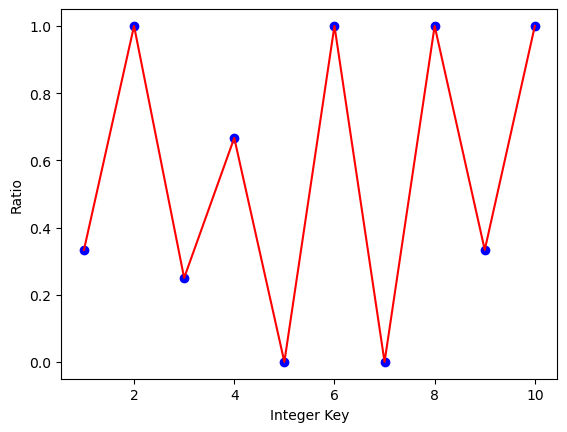

In [73]:
import matplotlib.pyplot as plt

def plot_dict(d):
    x_vals = []
    y_vals = []
    
    for key in sorted(d.keys()):
        lst = d[key]
        total_count = len(lst)
        
        if total_count == 0:
            ratio = 0
        else:
            non_neg_count = sum(1 for x in lst if x != -1)
            ratio = non_neg_count / total_count
            
        x_vals.append(key)
        y_vals.append(ratio)

    # Plotting the points as scatter plot
    plt.scatter(x_vals, y_vals, color='blue')
    
    # Connecting the points using line
    plt.plot(x_vals, y_vals, color='red')

    # Labeling the axes
    plt.xlabel('Integer Key')
    plt.ylabel('Ratio')

    # Showing the plot
    plt.show()

# Example usage
example_dict = {
    1: [-1, -1, (1, 2, 3)],
    2: [(2, 3, 4), (1, 2, 3)],
    3: [-1, -1, -1, (4, 5, 6)],
    4: [(3, 4, 5), -1, (5, 6, 7)],
    5: [-1, -1, -1, -1],
    6: [(6, 7, 8), (7, 8, 9)],
    7: [],
    8: [(1, 2, 3)],
    9: [-1, -1, (2, 3, 4)],
    10: [(1, 2, 3), (2, 3, 4), (3, 4, 5)]
}

plot_dict(example_dict)

# Experiment Paper

In [74]:
# # get problem matrix transport
# generate_problem_matrix("datasets/domain/0-transport/domain.pddl", 
#                         "datasets/domain/0-transport/train", 
#                         "datasets/domain/0-transport/plans", 
#                         "datasets/train_data", 
#                         "transport_train")

In [82]:
# # get problem matrix elevator
# generate_problem_matrix("datasets/domain/0-elevator/domain.pddl", 
#                         "datasets/domain/0-elevator/train", 
#                         "datasets/domain/0-elevator/plans", 
#                         "datasets/train_data", 
#                         "elevator_train")

In [77]:
# # get problem matrix parking
# generate_problem_matrix("datasets/domain/0-parking/domain.pddl", 
#                         "datasets/domain/0-parking/train", 
#                         "datasets/domain/0-parking/plans", 
#                         "datasets/train_data", 
#                         "parking_train")

In [87]:
# get problem matrix no-mystery
generate_problem_matrix("datasets/domain/0-no-mystery/domain.pddl", 
                        "datasets/domain/0-no-mystery/train", 
                        "datasets/domain/0-no-mystery/plans", 
                        "datasets/train_data", 
                        "transport_train")

next loop


KeyboardInterrupt: 

## transport

In [65]:
# train svm
svm_transport = RankSVM(C = 0.1)
results = np.load("datasets/train_data/transport_train.npz")
X = results['feature']
Y = results['label']

print(X.shape, Y.shape)

svm_transport.fit(X, Y)

svm_transport.coef_

(230, 25) (230, 2)


E:\Apps\Anaconda\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


array([[ 3.37526058e-02, -2.19874619e-02,  7.69458932e-02,
         1.92490182e-03, -1.03854357e-03,  1.35084008e-03,
        -1.48896301e-03,  0.00000000e+00,  9.84560404e-03,
         2.35378182e-03, -1.02214878e-03, -9.41028133e-04,
         9.30867065e-04,  0.00000000e+00,  6.00650085e-03,
        -1.61071881e-02,  0.00000000e+00,  3.77074176e-03,
         0.00000000e+00, -5.12168174e-02,  3.92929915e-02,
         1.51646871e-01,  8.47837829e-02, -5.61182381e-02,
         1.13416116e+00]])

In [64]:
# test result
# time limit is 10 min
result_list = test_domain("datasets/domain/0-transport/domain.pddl",
            "datasets/domain/0-transport/instance_uc",
            "datasets/domain/0-transport/plans",
            svm_transport,
            600) 

['instance-1', 'instance-10', 'instance-11', 'instance-12', 'instance-13', 'instance-14', 'instance-15', 'instance-16', 'instance-17', 'instance-18', 'instance-19', 'instance-2', 'instance-20', 'instance-3', 'instance-4', 'instance-5', 'instance-6', 'instance-7', 'instance-8', 'instance-9']
start generate problem instance for instance-1
start gbfs for instance-1
heristic values:124950
heristic values:121266
heristic values:122043
heristic values:124795
heristic values:122744
heristic values:124280
heristic values:123467
heristic values:123439
heristic values:126831
heristic values:122043
heristic values:124950
heristic values:124459
heristic values:123871
heristic values:123320
heristic values:120488
heristic values:119247
heristic values:119176
heristic values:125090
heristic values:120419
heristic values:123439
heristic values:122835
heristic values:122723
heristic values:118996
heristic values:118398
heristic values:117590
heristic values:121266
heristic values:119952
heristic value

heristic values:108884
heristic values:109684
heristic values:108272
heristic values:111946
heristic values:112574
heristic values:106402
heristic values:108272
heristic values:108914
heristic values:110054
heristic values:108899
heristic values:100747
heristic values:108272
heristic values:108272
heristic values:98389
heristic values:106970
heristic values:109617
heristic values:104317
heristic values:100748
heristic values:106402
heristic values:100747
heristic values:98745
heristic values:104976
heristic values:101407
heristic values:106943
heristic values:101610
heristic values:102526
heristic values:98389
heristic values:105024
heristic values:103092
heristic values:106402
heristic values:98389
heristic values:99503
heristic values:111253
heristic values:103131
heristic values:103990
heristic values:101440
heristic values:107846
heristic values:100226
heristic values:100747
heristic values:100695
heristic values:103859
heristic values:100117
heristic values:107846
heristic values:

heristic values:106328
heristic values:100212
heristic values:107564
heristic values:100748
heristic values:99210
heristic values:104811
heristic values:98574
heristic values:107775
heristic values:99645
heristic values:100406
heristic values:99189
heristic values:105509
heristic values:100212
heristic values:107775
heristic values:99392
heristic values:111826
heristic values:100272
heristic values:101445
heristic values:104228
heristic values:100253
heristic values:108475
heristic values:100263
heristic values:99306
heristic values:111432
heristic values:101610
heristic values:105301
heristic values:98749
heristic values:106198
heristic values:99738
heristic values:101004
heristic values:99510
heristic values:102633
heristic values:105250
heristic values:98383
heristic values:106198
heristic values:99962
heristic values:96848
heristic values:110475
heristic values:101375
heristic values:101047
heristic values:98027
heristic values:102998
heristic values:101004
heristic values:107564
h

heristic values:96848
heristic values:99962
heristic values:99189
heristic values:101976
heristic values:108384
heristic values:108384
heristic values:101004
heristic values:110818
heristic values:101047
heristic values:100248
heristic values:102713
heristic values:102713
heristic values:101232
heristic values:93702
heristic values:93672
heristic values:101578
heristic values:108961
heristic values:101117
heristic values:100178
heristic values:100178
heristic values:100178
heristic values:100248
heristic values:93702
heristic values:101903
heristic values:93945
heristic values:81433
heristic values:81433
heristic values:92775
heristic values:91621
heristic values:82923
heristic values:90269
heristic values:81706
heristic values:93672
heristic values:72512
heristic values:83854
heristic values:80306
heristic values:62187
heristic values:81303
heristic values:72785
heristic values:81433
heristic values:81433
heristic values:73563
heristic values:80306
heristic values:72512
heristic value

KeyboardInterrupt: 

# Experiment Own

In [133]:
# train blocks
generate_problem_matrix("datasets/domain/blocks/domain.pddl", 
                        "datasets/domain/blocks/train", 
                        "datasets/domain/blocks/plans", 
                        "datasets/results", 
                        "blocks-train")
svm_block = RankSVM(C = 0.1)
results = np.load("datasets/results/blocks-train.npz")
X = results['feature']
Y = results['label']

print(X.shape, Y.shape)

svm_block.fit(X, Y)

(94, 40) (94, 2)


E:\Apps\Anaconda\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


RankSVM(C=0.1)

In [134]:
# test blocks 1
test_plan = RelaxedPlanningGraph("datasets/domain/blocks/domain.pddl", 
                                 "datasets/domain/blocks/blocks/blocks3/task01.pddl")

rank_h = RankHeuristic(svm_block, test_plan)

rtn = gbfs(test_plan.task, rank_h)
print(f'Nodes expanded:{rank_h.expand_nodes}')
print(f'plan length{len(rtn)}')
rtn

reached goal state
Nodes expanded:4
plan length2


[<Op (unstack b3 b2)>, <Op (put-down b3)>]

In [137]:
result_dict_blocks = test_blocks("datasets/domain/blocks/domain.pddl",
            "datasets/domain/blocks/test-svm",
            "datasets/domain/blocks/plans",
            svm_block,
            3) 


['blocks3-task04', 'blocks3-task05', 'blocks3-task06', 'blocks3-task07', 'blocks3-task08', 'blocks3-task09', 'blocks3-task10', 'blocks4-task05', 'blocks4-task06', 'blocks4-task07', 'blocks4-task08', 'blocks4-task09', 'blocks4-task10', 'blocks5-task04', 'blocks5-task05', 'blocks5-task06', 'blocks5-task07', 'blocks5-task08', 'blocks5-task09', 'blocks5-task10', 'blocks6-task06', 'blocks6-task07', 'blocks6-task08', 'blocks6-task09', 'blocks6-task10', 'blocks7-task02', 'blocks7-task03', 'blocks7-task04', 'blocks7-task05', 'blocks8-task02', 'blocks8-task03', 'blocks8-task04']
reached goal state
next loop
reached goal state
next loop
reached goal state
next loop
reached goal state
next loop
reached goal state
next loop
reached goal state
next loop
reached goal state
next loop
reached goal state
next loop
reached goal state
next loop
reached goal state
next loop
reached goal state
next loop
reached goal state
next loop
reached goal state
next loop
reached goal state
next loop
reached goal stat

In [125]:
# test blocks 2
test_optimal("datasets/domain/blocks/domain.pddl",
            "datasets/domain/blocks/test-svm",
            "datasets/domain/blocks/plans",
            svm_block)

['blocks3-task04', 'blocks3-task05', 'blocks3-task06', 'blocks3-task07', 'blocks3-task08', 'blocks3-task09', 'blocks3-task10', 'blocks4-task05', 'blocks4-task06', 'blocks4-task07', 'blocks4-task08', 'blocks4-task09', 'blocks4-task10', 'blocks5-task04', 'blocks5-task05', 'blocks5-task06', 'blocks5-task07', 'blocks5-task08', 'blocks5-task09', 'blocks5-task10', 'blocks6-task06', 'blocks6-task07', 'blocks6-task08', 'blocks6-task09', 'blocks6-task10', 'blocks7-task02', 'blocks7-task03', 'blocks7-task04', 'blocks7-task05', 'blocks8-task02', 'blocks8-task03', 'blocks8-task04']
reached goal state
Nodes expanded:15
For problem blocks3-task04
get true optimal length 6
reached goal state
Nodes expanded:15
For problem blocks3-task05
get true optimal length 6
reached goal state
Nodes expanded:12
For problem blocks3-task06
get true optimal length 4
reached goal state
Nodes expanded:12
For problem blocks3-task07
get true optimal length 4
reached goal state
Nodes expanded:20
For problem blocks3-task08

KeyboardInterrupt: 

In [31]:
# train ferry
generate_problem_matrix("datasets/domain/ferry/domain.pddl", 
                        "datasets/domain/ferry/train", 
                        "datasets/domain/ferry/plans", 
                        "datasets/results", 
                        "ferry-train")

svm_ferry = RankSVM(C = 0.1)
results = np.load("datasets/results/ferry-train.npz")
X = results['feature']
Y = results['label']

print(X.shape, Y.shape)

svm_ferry.fit(X, Y)

(45, 25) (45, 2)


E:\Apps\Anaconda\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


RankSVM(C=0.1)

In [32]:
# test ferry 1
test_plan = RelaxedPlanningGraph("datasets/domain/ferry/domain.pddl", 
                                 "datasets/domain/ferry/test/ferry-l2-c15.pddl")

rank_h = RankHeuristic(svm_ferry, test_plan)

rtn = gbfs(test_plan.task, rank_h)
print(f'Nodes expanded:{rank_h.expand_nodes}')
print(f'plan length{len(rtn)}')
rtn


KeyboardInterrupt: 

In [156]:
# test ferry 2
test_optimal("datasets/domain/ferry/domain.pddl",
            "datasets/domain/ferry/test-svm",
            "datasets/domain/ferry/plans",
            svm_ferry)

['ferry-l2-c10', 'ferry-l2-c15', 'ferry-l2-c20', 'ferry-l2-c5', 'ferry-l3-c10', 'ferry-l3-c15', 'ferry-l3-c5', 'ferry-l4-c10', 'ferry-l4-c15', 'ferry-l4-c5', 'ferry-l5-c10', 'ferry-l5-c15', 'ferry-l5-c5']
reached goal state
Nodes expanded:38
For problem ferry-l2-c10
get true optimal length 10
reached goal state
Nodes expanded:376
For problem ferry-l2-c15
get true optimal length 21
reached goal state
Nodes expanded:1147
For problem ferry-l2-c20
my plan length: 28, optimal plan length: 25
reached goal state
Nodes expanded:17
For problem ferry-l2-c5
get true optimal length 6
reached goal state
Nodes expanded:118
For problem ferry-l3-c10
my plan length: 18, optimal plan length: 14
reached goal state
Nodes expanded:6649
For problem ferry-l3-c15
my plan length: 79, optimal plan length: 35
reached goal state
Nodes expanded:81
For problem ferry-l3-c5
my plan length: 17, optimal plan length: 15
reached goal state
Nodes expanded:524
For problem ferry-l4-c10
my plan length: 22, optimal plan lengt

0.38461538461538464

In [159]:
# train gripper
generate_problem_matrix("datasets/domain/gripper/domain.pddl", 
                        "datasets/domain/gripper/train", 
                        "datasets/domain/gripper/plans", 
                        "datasets/results", 
                        "gripper-train")
svm_gripper = RankSVM(C = 0.1)
results = np.load("datasets/results/gripper-train.npz")
X = results['feature']
Y = results['label']

print(X.shape, Y.shape)

svm_gripper.fit(X, Y)

(108, 24) (108, 2)


E:\Apps\Anaconda\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


RankSVM(C=0.1)

In [160]:
# test gripper 1
test_plan = RelaxedPlanningGraph("datasets/domain/gripper/domain.pddl", 
                                 "datasets/domain/gripper/test/gripper-n4.pddl")

rank_h = RankHeuristic(svm_gripper, test_plan)

rtn = gbfs(test_plan.task, rank_h)
print(f'Nodes expanded:{rank_h.expand_nodes}')
print(f'plan length{len(rtn)}')
rtn

reached goal state
Nodes expanded:48
plan length11


[<Op (pick ball2 rooma left)>,
 <Op (pick ball3 rooma right)>,
 <Op (move rooma roomb)>,
 <Op (drop ball2 roomb left)>,
 <Op (drop ball3 roomb right)>,
 <Op (move roomb rooma)>,
 <Op (pick ball4 rooma left)>,
 <Op (pick ball1 rooma right)>,
 <Op (move rooma roomb)>,
 <Op (drop ball4 roomb left)>,
 <Op (drop ball1 roomb right)>]

In [162]:
# test gripper 2
test_optimal("datasets/domain/gripper/domain.pddl",
            "datasets/domain/gripper/test-svm",
            "datasets/domain/gripper/plans",
            svm_gripper)

['gripper-n13', 'gripper-n14', 'gripper-n15', 'gripper-n16', 'gripper-n17', 'gripper-n4', 'gripper-n5', 'gripper-n6', 'gripper-n7', 'gripper-n8', 'gripper-n9']
reached goal state
Nodes expanded:377
For problem gripper-n13
get true optimal length 39
reached goal state
Nodes expanded:396
For problem gripper-n14
get true optimal length 41
reached goal state
Nodes expanded:476
For problem gripper-n15
get true optimal length 45
reached goal state
Nodes expanded:516
For problem gripper-n16
get true optimal length 47
reached goal state
Nodes expanded:608
For problem gripper-n17
get true optimal length 51
reached goal state
Nodes expanded:48
For problem gripper-n4
get true optimal length 11
reached goal state
Nodes expanded:77
For problem gripper-n5
get true optimal length 15
reached goal state
Nodes expanded:96
For problem gripper-n6
get true optimal length 17
reached goal state
Nodes expanded:128
For problem gripper-n7
get true optimal length 21
reached goal state
Nodes expanded:150
For prob

1.0

In [177]:
# train zeno
generate_problem_matrix("datasets/domain/zenotravel/domain.pddl", 
                        "datasets/domain/zenotravel/train", 
                        "datasets/domain/zenotravel/plans", 
                        "datasets/results", 
                        "zenotravel-train")
svm_zeno = RankSVM(C = 0.1)
results = np.load("datasets/results/zenotravel-train.npz")
X = results['feature']
Y = results['label']

print(X.shape, Y.shape)

svm_zeno.fit(X, Y)

(120, 58) (120, 2)


E:\Apps\Anaconda\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


RankSVM(C=0.1)

In [178]:
# test zeno 1
test_plan = RelaxedPlanningGraph("datasets/domain/zenotravel/domain.pddl", 
                                 "datasets/domain/zenotravel/test/zenotravel-cities2-planes2-people5-1564.pddl")

rank_h = RankHeuristic(svm_zeno, test_plan)

rtn = gbfs(test_plan.task, rank_h)
print(f'Nodes expanded:{rank_h.expand_nodes}')
print(f'plan length{len(rtn)}')
rtn

reached goal state
Nodes expanded:56
plan length6


[<Op (refuel plane2 city1 fl0 fl1)>,
 <Op (board person2 plane2 city1)>,
 <Op (refuel plane2 city1 fl1 fl2)>,
 <Op (fly plane2 city1 city0 fl2 fl1)>,
 <Op (debark person2 plane2 city0)>,
 <Op (fly plane2 city0 city1 fl1 fl0)>]

In [179]:
# test zeno 2
test_optimal("datasets/domain/zenotravel/domain.pddl",
            "datasets/domain/zenotravel/test-svm",
            "datasets/domain/zenotravel/plans",
            svm_zeno)

['zenotravel-cities2-planes3-people6-6510', 'zenotravel-cities2-planes3-people7-3468', 'zenotravel-cities2-planes4-people4-2248', 'zenotravel-cities2-planes4-people4-6874', 'zenotravel-cities2-planes4-people7-6599', 'zenotravel-cities2-planes5-people3-9854', 'zenotravel-cities3-planes2-people4-6913', 'zenotravel-cities3-planes2-people7-1956', 'zenotravel-cities3-planes3-people4-2981', 'zenotravel-cities4-planes4-people6-1235', 'zenotravel-cities4-planes4-people7-4853', 'zenotravel-cities4-planes5-people3-3894']
reached goal state
Nodes expanded:1191
For problem zenotravel-cities2-planes3-people6-6510
my plan length: 14, optimal plan length: 10
reached goal state
Nodes expanded:23566
For problem zenotravel-cities2-planes3-people7-3468
my plan length: 23, optimal plan length: 16


KeyboardInterrupt: 